こちらはRANSACを用いて自己位置推定を行うシミュレーション

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# LiDARのスペック
distance_range = (100, 30000) # mm 検出保証値
distance_accuracy = 30 # mm 検出精度
angular_range = 270 # degree 走査角度
angular_resolution = 0.25 # degree 分解能

ball_radius = 95 # mm 直径190mmのボール

# エリア2の寸法
corners2 = np.array([[0,0], [0,4000], [1075,4000], [1075,3500], [2075,3500], [2075,3000], [5875,3000], [5875,0]], dtype=np.float32)  # [x,y]
# エリア3の寸法
corners3 = np.array([[0,0], [0,4000], [5875,4000], [5875,0], [2075,0]], dtype=np.float32)  # [x,y]

# interpolate_boxを生成するための関数
def interpolate(corners, interval):
    """
    corners: np.array (n, 2) 部屋の頂点の座標の配列
    interval: float 補間する間隔
    """
    new_corners = []
    for i in range(len(corners)-1):
        new_corners.append(corners[i])
        diff = corners[i+1] - corners[i]
        num = int(np.linalg.norm(diff) / interval)
        for j in range(1, num):
            new_corners.append(corners[i] + diff * j / num)
    new_corners.append(corners[-1])
    return np.array(new_corners)

corners = corners2

まずは点群を作成します

これでロボットを原点とした点群の座標が得られた。ここからcenterの座標を求めていく。

処理時間:0.1256566047668457
更新回数:14


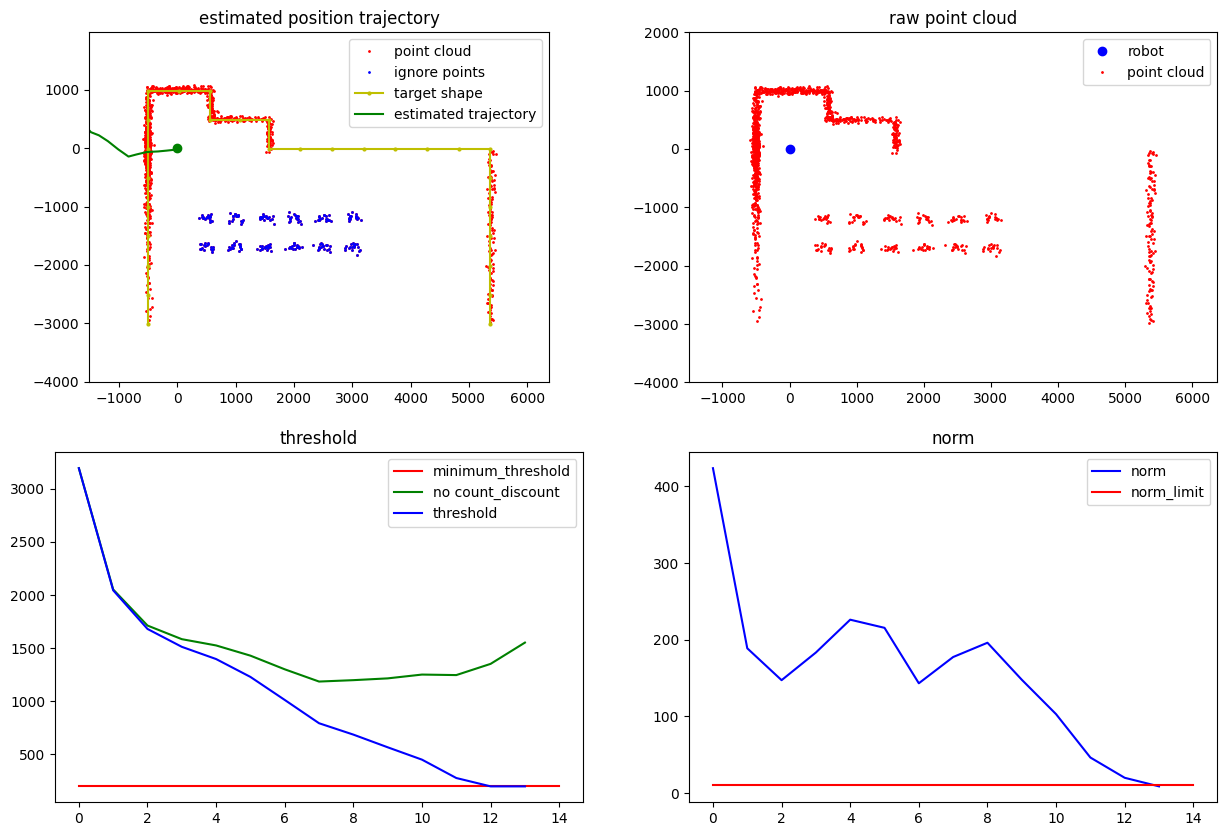

In [6]:

center = [500,3000] # lidarの位置

interpolated_corners = interpolate(corners, 500)

# lidarの点群をプロット
point_list = []

ball_pos_list = np.array([[1000, 1250],
                          [1500, 1250],
                          [2000, 1250],
                          [2500, 1250],
                          [3000, 1250],
                          [3500, 1250],
                          [1000, 1750],
                          [1500, 1750],
                          [2000, 1750],
                          [2500, 1750],
                          [3000, 1750],
                          [3500, 1750],])

for boll_pos in ball_pos_list:
    # 円形の点群を加える
    for angle in np.arange(0, 180, 10):
        theta = np.deg2rad(angle)
        x = np.cos(theta) * ball_radius + boll_pos[0] - center[0]
        y = np.sin(theta) * ball_radius + boll_pos[1] - center[1]
        point = np.array([x, y])
        point += np.random.normal(0, distance_accuracy, (2))
        point_list.append(point)

for angle in np.arange(0, 180, angular_resolution):
    theta = np.deg2rad(angle + angular_resolution/2)
    points = [[1e5, 1e5], [-1e5, -1e5]]
    for i in range(len(corners)-1):
        epsilon = 1e-6
        a, b = center
        p, q = corners[i]
        r, s = corners[i+1]
        x = (b - s - a*np.tan(theta) + r*(q - s)/(p - r + epsilon))/((q - s)/(p - r + epsilon) - np.tan(theta))
        y = np.tan(theta)*x + b - a*np.tan(theta)
        if (x - p)*(x - r) <= epsilon and (y - q)*(y - s) <= epsilon: # 線分上にあるか
            # x > center[0]の点からxが最も小さい点を選ぶ
            if x >= center[0]:
                if points[0][0] > x:
                    points[0] = [x, y]
            # x < center[0]の点からxが最も大きい点を選ぶ
            else:
                if points[1][0] < x:
                    points[1] = [x, y]
    points = np.array(points)
    # 点にノイズを加える
    points += np.random.normal(0, distance_accuracy, (2,2))
    # 点をcentorとの相対座標に変換
    points -= center
    point_list.append(points[0])
    point_list.append(points[1])
point_list = np.array(point_list)

##############################################点群生成ここまで##############################################

# 外れ値を除去
point_list = point_list[np.abs(point_list[:,0]) < 10000] # 10m以上の点を除去
point_list = point_list[np.abs(point_list[:,1]) < 10000] # 10m以上の点を除去
# 重心を求める
center_of_gravity = np.mean(point_list, axis=0)
# 実際の実装では初期位置を重心ではなく，前回の位置にすると収束が早いかもしれない
# 重心を中心としたboxを配置
box = interpolated_corners + center_of_gravity
box -= np.array([max(interpolated_corners[:,0])/2, max(interpolated_corners[:,1])/2]) # 重心を中心にする

# どの程度はなれていたら外れ値とみなすか
def update_box(box, point_list, threshold=1000, norm_limit=5):
    max_error = 0
    diff = [0, 0] # x, y座標のそれぞれのずれを保存するリスト
    
    # デバッグ用に無視された点群を保存する
    ignore_points = []
    
    for point in point_list:
        distances = np.linalg.norm(box - point, axis=1)
        closest_indices = np.argsort(distances)[:2]
        closest_points = box[closest_indices] # 最も近い2点
        if closest_points[0][0] == closest_points[1][0]: # x座標が同じ場合
            error = closest_points[0][0] - point[0] # x座標のずれ 絶対値ではないことに注意
            if error**2 < threshold**2: # ノイズへの対処
                diff[0] += error
            else: # 外れ値の場合は無視
                ignore_points.append(point)
            error = abs(error)
            if error > max_error:
                max_error = error
        elif closest_points[0][1] == closest_points[1][1]: # y座標が同じ場合
            error = closest_points[0][1] - point[1] # y座標のずれ
            if error**2 < threshold**2:
                diff[1] += error
            else:
                ignore_points.append(point)
            error = abs(error)
            if error > max_error:
                max_error = error
        else: # x座標もy座標も異なる場合。これは箱から十分に離れていると考えられる
            ignore_points.append(point)
    diff = np.array(diff) / len(point_list) # 平均を取る
    # print(f"更新:{diff}")
    box -= diff # ずれを適用
    # print(f"推定されたロボットの位置:{-box[0]}")
    # print(f"ロボットの位置の誤差:{center + box[0]}mm")
    done = False
    if np.linalg.norm(diff) < norm_limit:
        done = True
    return box, max_error, ignore_points, done, np.linalg.norm(diff)

def calc_threshold(max_error, count, minimum_threshold=200, error_discount=0.8, count_discount=8):
    return max(max_error*error_discount - count_discount*count*count, minimum_threshold)

# 更新の軌跡を保存
update_list = np.array([box[0].copy()+center])
max_error = 4000
ignore_points = []
count = 0
thereshold_list = []
norm_list = []
norm_limit = 10 # 許容する誤差の大きさ
minimum_threshold = 200
error_discount = 0.8 # 0.8
count_discount = 8 # 8

# 処理速度を計測
import time
start = time.time()
done = False
while not done:
    count += 1
    threshold = calc_threshold(max_error, count, minimum_threshold=minimum_threshold, error_discount=error_discount, count_discount=count_discount)
    thereshold_list.append(threshold)
    # print(f"threshold:{threshold}")
    box, max_error, ignore_points, done, norm = update_box(box, point_list, threshold=threshold, norm_limit=norm_limit)
    if count < 10: # 最低でも10回は更新を行う
        done = False
    norm_list.append(norm)
    update_list = np.append(update_list, np.array(box[0].copy()+center).reshape(1, -1), axis=0)
print(f"処理時間:{time.time()-start}")
print(f"更新回数:{count}")

##############################################描画ここから##############################################

# 2つのグラフを描画
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
# グラフの範囲を指定
ax[0,0].set_xlim(min(box[:,0])-1000, max(box[:,0])+1000)
ax[0,0].set_ylim(min(box[:,1])-1000, max(box[:,1])+1000)
# x軸とy軸のスケールを合わせる
ax[0,0].set_aspect('equal')
# lidarの位置をプロット
ax[0,0].plot(0, 0, 'go')
# 点群をプロット
ax[0,0].plot(point_list[:,0], point_list[:,1],'ro', markersize=1, label="point cloud")
# アルゴリズムによって無視された点群をプロット
ignore_points = np.array(ignore_points)
ax[0,0].plot(ignore_points[:,0], ignore_points[:,1], 'bo', markersize=1, label="ignore points")
# 検出目標の形状をプロット
ax[0,0].plot(box[:,0], box[:,1], 'yo-', markersize=2, label="target shape")
# 更新の軌跡をプロット
ax[0,0].plot(update_list[:,0], update_list[:,1], 'g-', label="estimated trajectory")
ax[0,0].set_title("estimated position trajectory")
# labelの位置を自動調整
ax[0,0].legend(loc='upper right')

ax[0,1].plot(0, 0, 'bo', label="robot")
ax[0,1].plot(point_list[:,0], point_list[:,1], 'ro', markersize=1, label="point cloud")
ax[0,1].set_title("raw point cloud")
ax[0,1].legend(loc='upper right')
ax[0,1].set_xlim(min(corners[:,0])-1000-center[0], max(corners[:,0])+1000-center[0])
ax[0,1].set_ylim(min(corners[:,1])-1000-center[1], max(corners[:,1])+1000-center[1])

ax[1,0].set_title("threshold")
ax[1,0].plot([0, count], [minimum_threshold, minimum_threshold], 'r-', label="minimum_threshold")
count_list = np.arange(0, count)
count_discount_list = count_discount * count_list**2 + thereshold_list
ax[1,0].plot(count_list, count_discount_list, 'g-', label="no count_discount")
ax[1,0].plot(thereshold_list, 'b-', label="threshold")
ax[1,0].legend(loc='upper right')

ax[1,1].plot(norm_list, 'b-', label="norm")
# norm_limitをプロット
ax[1,1].plot([0, count], [norm_limit, norm_limit], 'r-', label="norm_limit")
ax[1,1].set_title("norm")
ax[1,1].legend(loc='upper right')
plt.show()

何度か繰り返すとBoxが点群にフィットするようになる。

計算としては次のようなことをしている。
1. 点群のすべての点に対してbox内から最も近い2点を取り出す。
2. 点と，2点を結んだ直線を最短で結ぶベクトルを求める。この時，boxの形状が既知であること，すべての辺が軸に平行/垂直であることを利用して  
・選ばれた2点のx座標が同じならば，２点のx座標と点のx座標の差をx軸の誤差に加算する  
・選ばれた2点のy座標が同じならば，２点のy座標と点のy座標の差をy軸の誤差に加算する  
という簡単な計算によってベクトルの和を求めることができる。
3. ベクトルの和をある程度の値(今回は点群の数)で割って，その値分，boxを動かす。
4. これを何度か繰り返すことで点群はboxにフィットし，ロボットの位置が求まる。

以上によりRANSACなどを用いた場合よりも軽量に自己位置を推定できると思われる。
BOXは検出したい形状の角の座標の配列であり，これを細かく線形補完するほど精度が上がる。